# SLSQP-JAX: CPU vs GPU Benchmark

This notebook benchmarks the [slsqp-jax](https://github.com/lucianopaz/slsqp-jax) constrained optimizer across problem sizes to compare **JAX CPU**, **JAX GPU**, and **SciPy** execution times.

We solve constrained quadratic problems at dimensions **n = 5, 20, 100, 500, 1000** and
report wall-clock times for all backends. Finally, we tackle a **100,000-dimensional constrained portfolio allocation** on both CPU and GPU to demonstrate large-scale capability.

> **Requirements** — Run this notebook on Google Colab with a **GPU runtime**.\
> Go to **Runtime → Change runtime type → T4 GPU** (or better).

In [1]:
# Upgrade JAX + CUDA plugin to a compatible set, then install slsqp-jax.
# Colab ships an older jax-cuda12-plugin that is incompatible with jax>=0.9.
!uv pip install jax[cuda12] git+https://github.com/lucianopaz/slsqp-jax.git -q

In [2]:
import time

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optimistix as optx

from slsqp_jax import SLSQP

# Enable 64-bit precision for numerical accuracy
jax.config.update("jax_enable_x64", True)

# --- Hardware verification ---
print(f"JAX version : {jax.__version__}")
print(f"All devices : {jax.devices()}")

try:
    gpu_devices = jax.devices("gpu")
    print(f"\u2705 GPU detected: {gpu_devices}")
    gpu_available = True
except RuntimeError:
    print("\u274c No GPU found. Enable GPU in Runtime > Change runtime type.")
    gpu_available = False

cpu_device = jax.devices("cpu")[0]
gpu_device = jax.devices("gpu")[0] if gpu_available else cpu_device

JAX version : 0.9.0.1
All devices : [CudaDevice(id=0)]
✅ GPU detected: [CudaDevice(id=0)]


## CPU vs GPU Benchmark

For each problem dimension **n**, we create a constrained weighted quadratic:

$$
\min_x \sum_{i=1}^n w_i\,(x_i - t_i)^2
\quad\text{s.t.}\quad
\sum_i x_i = n,\;\; x_j \ge 0 \;\text{for}\; j=0,\dots,3
$$

where $w_i$ are linearly spaced in $[1,\,10]$, and the target $t_i = -2$ for the first 4 variables and $t_i = 1$ for the rest. The 4 box constraints are **active** at the solution (the solver wants $x_{0..3} = -2$ but is prevented), while only 5 total constraints keep the QP subproblem's $AA^T$ system at a
numerically stable $5 \times 5$.

Each benchmark:
1. JIT-compiles the full `optimistix.minimise` call (all SLSQP iterations compiled into a single XLA program).
2. Runs a **warmup** pass to trigger compilation.
3. Times multiple post-compilation runs and reports the average.

> **Note on GPU vs CPU for iterative solvers** — SLSQP uses `jax.lax.while_loop` for the outer iteration and the active-set QP subproblem. Each loop iteration incurs GPU kernel-launch and host-device synchronisation overhead. For small to moderate **n** the per-step linear algebra (O(kn) L-BFGS HVPs, O(mn) projections)
> is too cheap to offset that overhead, so **CPU is expected to be faster** at these sizes. The GPU advantage appears for large **n** (thousands of variables) where the vectorised operations dominate — as demonstrated in the 100k portfolio problem at the end of this notebook.

In [3]:
from scipy.optimize import minimize as scipy_minimize

N_INEQ = 4  # fixed number of box constraints (independent of n)


def make_benchmark_problem(n):
    """Create a constrained quadratic with 1 equality + 4 inequality constraints.

    The first 4 variables target -2 (but are constrained >= 0), so the
    inequality constraints are active at the solution.  The remaining
    n-4 variables target 1 and are unconstrained from below.

    Returns (solver, objective, x0, scipy_problem_dict).
    """
    weights = jnp.linspace(1.0, 10.0, n)
    target = jnp.ones(n).at[: min(N_INEQ, n)].set(-2.0)

    # Convert to numpy for scipy compatibility
    weights_np = np.asarray(weights)
    target_np = np.asarray(target)

    def objective(x, args):
        return jnp.sum(weights * (x - target) ** 2), None

    def eq_constraint(x, args):
        return jnp.array([jnp.sum(x) - float(n)])

    n_ineq = min(N_INEQ, n)

    def ineq_constraint(x, args):
        return x[:n_ineq]  # x[0], ..., x[n_ineq-1] >= 0

    solver = SLSQP(
        rtol=1e-6,
        atol=1e-6,
        max_steps=200,
        eq_constraint_fn=eq_constraint,
        n_eq_constraints=1,
        ineq_constraint_fn=ineq_constraint,
        n_ineq_constraints=n_ineq,
        lbfgs_memory=10,
    )

    # SciPy problem definition (for comparison)
    def scipy_objective(x):
        return np.sum(weights_np * (x - target_np) ** 2)

    def scipy_eq_constraint(x):
        return np.sum(x) - float(n)

    scipy_constraints = [
        {"type": "eq", "fun": scipy_eq_constraint},
    ]
    # Add inequality constraints: x[i] >= 0 for i in range(n_ineq)
    for i in range(n_ineq):
        scipy_constraints.append({"type": "ineq", "fun": lambda x, i=i: x[i]})

    scipy_problem = {
        "fun": scipy_objective,
        "constraints": scipy_constraints,
    }

    x0 = jnp.ones(n)  # feasible: sum = n, x[:4] = 1 >= 0
    return solver, objective, x0, scipy_problem


def solve_with_scipy(scipy_problem, x0_np):
    """Solve the problem using scipy.optimize.minimize with SLSQP.

    Returns (solution, time_seconds, success).
    """
    t0 = time.perf_counter()
    result = scipy_minimize(
        scipy_problem["fun"],
        x0_np,
        method="SLSQP",
        constraints=scipy_problem["constraints"],
        options={"ftol": 1e-9, "maxiter": 200},
    )
    elapsed = time.perf_counter() - t0
    return result.x, elapsed, result.success


def check_solutions_match(sol_jax, sol_scipy, rtol=1e-4, atol=1e-5):
    """Check if JAX and SciPy solutions match within tolerance.

    Returns (match, max_diff).
    """
    sol_jax_np = np.asarray(sol_jax)
    sol_scipy_np = np.asarray(sol_scipy)

    # Handle NaN in JAX solution
    if np.any(np.isnan(sol_jax_np)):
        return False, np.inf

    diff = np.abs(sol_jax_np - sol_scipy_np)
    max_diff = float(np.max(diff))
    match = np.allclose(sol_jax_np, sol_scipy_np, rtol=rtol, atol=atol)

    return match, max_diff


def benchmark_on_device(solve_fn, x0, device, n_loops=10):
    """Benchmark a JIT-compiled solve function on *device*.

    Returns (avg_seconds, std_seconds, solution_array).
    """
    x0_dev = jax.device_put(x0, device)

    # Warmup — triggers JIT compilation for this device
    result = solve_fn(x0_dev)
    result.block_until_ready()

    # Timed runs
    times = []
    for _ in range(n_loops):
        t0 = time.perf_counter()
        result = solve_fn(x0_dev)
        result.block_until_ready()  # critical for async GPU dispatch
        times.append(time.perf_counter() - t0)

    return float(np.mean(times)), float(np.std(times)), np.asarray(result)

In [4]:
# ---- Run benchmarks --------------------------------------------------------
problem_sizes = [5, 20, 100, 500, 1000]
n_loops = 10

all_results = {}

for n in problem_sizes:
    print(f"\n{'=' * 65}")
    print(f" Problem dimension  n = {n}")
    print(f"{'=' * 65}")

    solver, objective, x0, scipy_problem = make_benchmark_problem(n)

    # Build a single JIT-compiled function for this problem.
    # Passing solver/objective via default-arg capture so each
    # iteration of the loop gets its own compiled function.
    @jax.jit
    def solve(x0, _s=solver, _o=objective):
        sol = optx.minimise(
            _o,
            _s,
            x0,
            has_aux=True,
            max_steps=200,
            throw=False,
        )
        return sol.value

    entry = {}

    # --- SciPy reference ---
    print("  Running SciPy SLSQP ...", end=" ", flush=True)
    x0_np = np.asarray(x0)
    scipy_sol, scipy_time, scipy_success = solve_with_scipy(scipy_problem, x0_np)
    print(f"done  →  {scipy_time * 1000:8.2f} ms (success={scipy_success})")
    entry["scipy"] = {"time": scipy_time, "sol": scipy_sol, "success": scipy_success}

    # --- CPU ---
    print("  Compiling for CPU ...", end=" ", flush=True)
    cpu_avg, cpu_std, cpu_sol = benchmark_on_device(
        solve,
        x0,
        cpu_device,
        n_loops,
    )
    print(f"done  →  {cpu_avg * 1000:8.2f} ± {cpu_std * 1000:.2f} ms")
    entry["cpu"] = {"avg": cpu_avg, "std": cpu_std, "sol": cpu_sol}

    # Check CPU vs SciPy match
    cpu_match, cpu_max_diff = check_solutions_match(cpu_sol, scipy_sol)
    entry["cpu"]["match_scipy"] = cpu_match
    entry["cpu"]["max_diff"] = cpu_max_diff

    # --- GPU ---
    if gpu_available:
        print("  Compiling for GPU ...", end=" ", flush=True)
        gpu_avg, gpu_std, gpu_sol = benchmark_on_device(
            solve,
            x0,
            gpu_device,
            n_loops,
        )
        print(f"done  →  {gpu_avg * 1000:8.2f} ± {gpu_std * 1000:.2f} ms")
        entry["gpu"] = {"avg": gpu_avg, "std": gpu_std, "sol": gpu_sol}
        speedup = cpu_avg / gpu_avg
        print(f"  Speedup: {speedup:.2f}x")

        # Check GPU vs SciPy match
        gpu_match, gpu_max_diff = check_solutions_match(gpu_sol, scipy_sol)
        entry["gpu"]["match_scipy"] = gpu_match
        entry["gpu"]["max_diff"] = gpu_max_diff

    # Sanity checks — finite, constraints satisfied
    print("\n  Solution validation:")

    # SciPy solution check
    scipy_eq_viol = float(np.abs(np.sum(scipy_sol) - float(n)))
    scipy_ineq_min = float(np.min(scipy_sol[: min(N_INEQ, n)]))
    print(f"    SciPy: |sum(x)-n|={scipy_eq_viol:.2e}, min(x[:4])={scipy_ineq_min:.2e}")

    # CPU solution check
    is_finite = bool(jnp.all(jnp.isfinite(jnp.asarray(cpu_sol))))
    eq_viol = float(jnp.abs(jnp.sum(jnp.asarray(cpu_sol)) - float(n)))
    ineq_min = float(jnp.min(jnp.asarray(cpu_sol[: min(N_INEQ, n)])))
    match_str = "✓" if cpu_match else f"✗ (max_diff={cpu_max_diff:.2e})"
    print(
        f"    CPU:   finite={is_finite}, |sum(x)-n|={eq_viol:.2e}, "
        f"min(x[:4])={ineq_min:.2e}, match_scipy={match_str}"
    )

    if gpu_available:
        is_finite = bool(jnp.all(jnp.isfinite(jnp.asarray(gpu_sol))))
        eq_viol = float(jnp.abs(jnp.sum(jnp.asarray(gpu_sol)) - float(n)))
        ineq_min = float(jnp.min(jnp.asarray(gpu_sol[: min(N_INEQ, n)])))
        match_str = "✓" if gpu_match else f"✗ (max_diff={gpu_max_diff:.2e})"
        print(
            f"    GPU:   finite={is_finite}, |sum(x)-n|={eq_viol:.2e}, "
            f"min(x[:4])={ineq_min:.2e}, match_scipy={match_str}"
        )

    all_results[n] = entry


 Problem dimension  n = 5
  Running SciPy SLSQP ... done  →     15.84 ms (success=True)
  Compiling for CPU ... done  →     29.42 ± 1.42 ms
  Compiling for GPU ... done  →    258.23 ± 37.24 ms
  Speedup: 0.11x

  Solution validation:
    SciPy: |sum(x)-n|=0.00e+00, min(x[:4])=-2.92e-13
    CPU:   finite=True, |sum(x)-n|=0.00e+00, min(x[:4])=-2.84e-16, match_scipy=✓
    GPU:   finite=True, |sum(x)-n|=0.00e+00, min(x[:4])=-2.84e-16, match_scipy=✓

 Problem dimension  n = 20
  Running SciPy SLSQP ... done  →     49.88 ms (success=True)
  Compiling for CPU ... done  →    243.01 ± 53.96 ms
  Compiling for GPU ... done  →   2120.64 ± 101.14 ms
  Speedup: 0.11x

  Solution validation:
    SciPy: |sum(x)-n|=0.00e+00, min(x[:4])=-2.79e-14
    CPU:   finite=True, |sum(x)-n|=1.80e-09, min(x[:4])=-4.41e-09, match_scipy=✓
    GPU:   finite=True, |sum(x)-n|=1.80e-09, min(x[:4])=-4.41e-09, match_scipy=✓

 Problem dimension  n = 100
  Running SciPy SLSQP ... done  →    169.45 ms (success=True)
  Comp

In [5]:
# ---- Summary table ---------------------------------------------------------
print()
print("=" * 110)
print(" BENCHMARK SUMMARY")
print("=" * 110)
header = f"{'n':>6} | {'SciPy (ms)':>12} | {'JAX CPU (ms)':>14} | {'JAX GPU (ms)':>14} | {'CPU vs SciPy':>12} | {'GPU vs SciPy':>12} | {'Match':>6}"
print(header)
print("-" * 110)

for n in problem_sizes:
    scipy_ms = all_results[n]["scipy"]["time"] * 1000
    cpu_ms = all_results[n]["cpu"]["avg"] * 1000
    cpu_match = "✓" if all_results[n]["cpu"]["match_scipy"] else "✗"

    # Speedup relative to SciPy (>1 means JAX is faster)
    cpu_speedup = all_results[n]["scipy"]["time"] / all_results[n]["cpu"]["avg"]

    row = f"{n:>6} | {scipy_ms:>10.2f} | {cpu_ms:>12.2f} ms"
    if gpu_available and "gpu" in all_results[n]:
        gpu_ms = all_results[n]["gpu"]["avg"] * 1000
        gpu_speedup = all_results[n]["scipy"]["time"] / all_results[n]["gpu"]["avg"]
        gpu_match = "✓" if all_results[n]["gpu"]["match_scipy"] else "✗"
        row += f" | {gpu_ms:>12.2f} ms | {cpu_speedup:>10.2f}x | {gpu_speedup:>10.2f}x | {cpu_match}/{gpu_match}"
    else:
        row += f" | {'N/A':>14} | {cpu_speedup:>10.2f}x | {'N/A':>12} | {cpu_match}"
    print(row)

print()
print("Speedup: >1 means JAX is faster than SciPy, <1 means SciPy is faster")
print("Match column: CPU/GPU vs SciPy reference solution (✓ = match, ✗ = mismatch)")


 BENCHMARK SUMMARY
     n |   SciPy (ms) |   JAX CPU (ms) |   JAX GPU (ms) | CPU vs SciPy | GPU vs SciPy |  Match
--------------------------------------------------------------------------------------------------------------
     5 |      15.84 |        29.42 ms |       258.23 ms |       0.54x |       0.06x | ✓/✓
    20 |      49.88 |       243.01 ms |      2120.64 ms |       0.21x |       0.02x | ✓/✓
   100 |     169.45 |       143.93 ms |      1449.21 ms |       1.18x |       0.12x | ✓/✓
   500 |    1531.42 |       465.34 ms |      3072.57 ms |       3.29x |       0.50x | ✗/✗
  1000 |    8467.88 |       859.25 ms |      3027.39 ms |       9.85x |       2.80x | ✓/✓

Speedup: >1 means JAX is faster than SciPy, <1 means SciPy is faster
Match column: CPU/GPU vs SciPy reference solution (✓ = match, ✗ = mismatch)


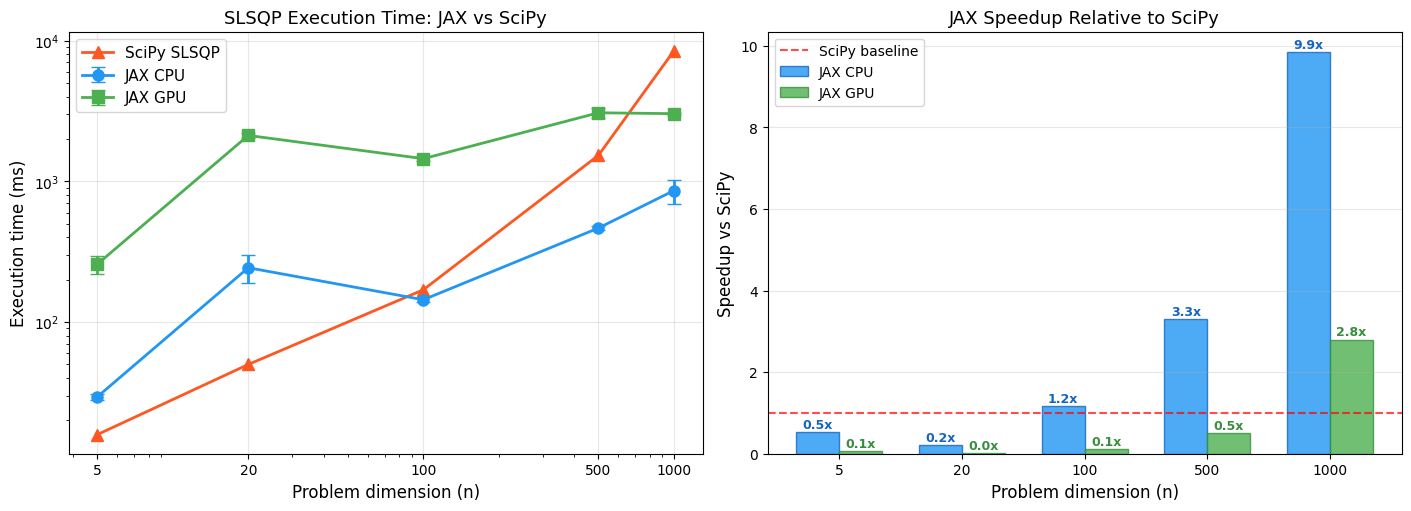

In [6]:
# ---- Plots -----------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5), layout="constrained")
sizes = np.array(problem_sizes)

# Extract timing data
scipy_times = np.array([all_results[n]["scipy"]["time"] * 1000 for n in problem_sizes])
cpu_times = np.array([all_results[n]["cpu"]["avg"] * 1000 for n in problem_sizes])
cpu_stds = np.array([all_results[n]["cpu"]["std"] * 1000 for n in problem_sizes])

# -- Left panel: execution times (including SciPy) --
ax = axes[0]

# SciPy reference line
ax.plot(
    sizes,
    scipy_times,
    marker="^",
    linewidth=2,
    markersize=8,
    color="#FF5722",
    label="SciPy SLSQP",
)

# JAX CPU
ax.errorbar(
    sizes,
    cpu_times,
    yerr=cpu_stds,
    marker="o",
    capsize=5,
    linewidth=2,
    markersize=8,
    color="#2196F3",
    label="JAX CPU",
)

if gpu_available:
    gpu_times = np.array([all_results[n]["gpu"]["avg"] * 1000 for n in problem_sizes])
    gpu_stds = np.array([all_results[n]["gpu"]["std"] * 1000 for n in problem_sizes])
    ax.errorbar(
        sizes,
        gpu_times,
        yerr=gpu_stds,
        marker="s",
        capsize=5,
        linewidth=2,
        markersize=8,
        color="#4CAF50",
        label="JAX GPU",
    )

ax.set_xlabel("Problem dimension (n)", fontsize=12)
ax.set_ylabel("Execution time (ms)", fontsize=12)
ax.set_title("SLSQP Execution Time: JAX vs SciPy", fontsize=13)
ax.legend(fontsize=11)
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True, alpha=0.3)
ax.set_xticks(problem_sizes)
ax.set_xticklabels(problem_sizes)

# -- Right panel: speedup relative to SciPy --
ax = axes[1]

# Speedups relative to SciPy (>1 means JAX is faster)
cpu_speedups = scipy_times / cpu_times

x_positions = np.arange(len(sizes))
bar_width = 0.35

# JAX CPU bars
cpu_bars = ax.bar(
    x_positions - bar_width / 2,
    cpu_speedups,
    bar_width,
    color="#2196F3",
    alpha=0.8,
    edgecolor="#1565C0",
    label="JAX CPU",
)

if gpu_available:
    gpu_speedups = scipy_times / gpu_times
    # JAX GPU bars
    gpu_bars = ax.bar(
        x_positions + bar_width / 2,
        gpu_speedups,
        bar_width,
        color="#4CAF50",
        alpha=0.8,
        edgecolor="#388E3C",
        label="JAX GPU",
    )

ax.axhline(
    y=1.0, color="red", linestyle="--", linewidth=1.5, alpha=0.7, label="SciPy baseline"
)
ax.set_ylabel("Speedup vs SciPy", fontsize=12)
ax.set_xlabel("Problem dimension (n)", fontsize=12)
ax.set_title("JAX Speedup Relative to SciPy", fontsize=13)
ax.set_xticks(x_positions)
ax.set_xticklabels([str(s) for s in sizes])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis="y")

# Annotate CPU bars
for bar, sp in zip(cpu_bars, cpu_speedups):
    y_pos = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        y_pos + 0.02,
        f"{sp:.1f}x",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold",
        color="#1565C0",
    )

# Annotate GPU bars
if gpu_available:
    for bar, sp in zip(gpu_bars, gpu_speedups):
        y_pos = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            y_pos + 0.02,
            f"{sp:.1f}x",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold",
            color="#388E3C",
        )

plt.show()

## Large-Scale: 100,000-Dimensional Portfolio Allocation

We now solve a constrained optimization problem with **n = 100,000** decision variables, modelling a simplified portfolio allocation over a universe of assets.

| Component | Formula |
|---|---|
| **Objective** | $\min_x\; \sum_i \sigma_i^2 x_i^2 - \sum_i \mu_i x_i$ |
| **Budget** (equality) | $\sum_i x_i = 1$ |
| **Sector caps** (inequality) | $\sum_{i \in S_k} x_i \le 0.15$ for each of $K{=}20$ sectors |

- $\sigma_i \in [0.05, 0.50]$ : per-asset volatility (random)
- $\mu_i \in [0.01, 0.15]$ : expected return (random)
- Each asset is randomly assigned to one of 20 sectors.

This gives **100,000 decision-variable dimensions** with only **21 constraints** (1 equality + 20 inequality), which keeps the QP subproblem's active-set projection fast ($21 \times 21$ system) while exercising the L-BFGS Hessian and projected CG at scale.

We benchmark this problem on **both CPU and GPU** to compare runtimes at large scale, where GPU parallelism should provide significant speedup.

In [7]:
N_LARGE = 100_000
K_SECTORS = 20
SECTOR_CAP = 0.15  # max 15 % in any one sector

# --- Generate random market parameters ---
key = jax.random.PRNGKey(0)
k1, k2, k3 = jax.random.split(key, 3)

sector_ids = jax.random.randint(k1, (N_LARGE,), 0, K_SECTORS)
volatilities = jax.random.uniform(k2, (N_LARGE,), minval=0.05, maxval=0.50)
expected_returns = jax.random.uniform(k3, (N_LARGE,), minval=0.01, maxval=0.15)


def portfolio_objective(x, args):
    """Risk-adjusted objective: variance - expected return."""
    variance = jnp.sum(volatilities**2 * x**2)
    exp_return = jnp.sum(expected_returns * x)
    return variance - exp_return, None


def budget_constraint(x, args):
    """Fully-invested: sum(x) = 1."""
    return jnp.array([jnp.sum(x) - 1.0])


def sector_constraint(x, args):
    """Sector caps: sum of allocations in each sector <= SECTOR_CAP.

    Returns cap - sector_sum >= 0 for each sector.
    """
    sector_allocs = jnp.zeros(K_SECTORS).at[sector_ids].add(x)
    return SECTOR_CAP - sector_allocs


solver_100k = SLSQP(
    rtol=1e-5,
    atol=1e-5,
    max_steps=500,
    eq_constraint_fn=budget_constraint,
    n_eq_constraints=1,
    ineq_constraint_fn=sector_constraint,
    n_ineq_constraints=K_SECTORS,
    lbfgs_memory=15,
    qp_max_iter=200,
    qp_max_cg_iter=100,
)

# Equal-weight starting point (feasible: each sector gets ~5 %)
x0_100k = jnp.ones(N_LARGE) / N_LARGE

print("Problem setup")
print(f"  Decision variables      : {N_LARGE:,}")
print("  Equality constraints    : 1")
print(f"  Inequality constraints  : {K_SECTORS}")
print(f"  Total constraints       : {K_SECTORS + 1}")


@jax.jit
def solve_100k(x0):
    sol = optx.minimise(
        portfolio_objective,
        solver_100k,
        x0,
        has_aux=True,
        max_steps=500,
        throw=False,
    )
    return sol.value


n_runs = 5
results_100k = {}

# --- CPU benchmark ---
print("\n" + "=" * 60)
print(" CPU BENCHMARK")
print("=" * 60)
x0_cpu = jax.device_put(x0_100k, cpu_device)

print("Compiling for CPU (this may take a minute or two) ...")
t0 = time.perf_counter()
result_cpu = solve_100k(x0_cpu)
result_cpu.block_until_ready()
cpu_compile_time = time.perf_counter() - t0
print(f"CPU compilation time: {cpu_compile_time:.1f} s")

print(f"\nRunning {n_runs} timed solves on CPU ...")
cpu_times = []
for _ in range(n_runs):
    t0 = time.perf_counter()
    result_cpu = solve_100k(x0_cpu)
    result_cpu.block_until_ready()
    cpu_times.append(time.perf_counter() - t0)

cpu_avg = np.mean(cpu_times)
cpu_std = np.std(cpu_times)
print(f"Average solve time (CPU): {cpu_avg:.2f} ± {cpu_std:.2f} s")
results_100k["cpu"] = {"avg": cpu_avg, "std": cpu_std, "sol": result_cpu}

# --- GPU benchmark ---
if gpu_available:
    print("\n" + "=" * 60)
    print(" GPU BENCHMARK")
    print("=" * 60)
    x0_gpu = jax.device_put(x0_100k, gpu_device)

    print("Compiling for GPU (this may take a minute or two) ...")
    t0 = time.perf_counter()
    result_gpu = solve_100k(x0_gpu)
    result_gpu.block_until_ready()
    gpu_compile_time = time.perf_counter() - t0
    print(f"GPU compilation time: {gpu_compile_time:.1f} s")

    print(f"\nRunning {n_runs} timed solves on GPU ...")
    gpu_times = []
    for _ in range(n_runs):
        t0 = time.perf_counter()
        result_gpu = solve_100k(x0_gpu)
        result_gpu.block_until_ready()
        gpu_times.append(time.perf_counter() - t0)

    gpu_avg = np.mean(gpu_times)
    gpu_std = np.std(gpu_times)
    print(f"Average solve time (GPU): {gpu_avg:.2f} ± {gpu_std:.2f} s")
    results_100k["gpu"] = {"avg": gpu_avg, "std": gpu_std, "sol": result_gpu}

    # Use GPU result for analysis (more accurate on GPU)
    result_100k = result_gpu
else:
    result_100k = result_cpu

# --- Summary comparison ---
print("\n" + "=" * 60)
print(" 100K PORTFOLIO: CPU vs GPU COMPARISON")
print("=" * 60)
print(f"\n{'Device':<10} | {'Avg Time (s)':<14} | {'Std (s)':<10}")
print("-" * 40)
print(f"{'CPU':<10} | {cpu_avg:<14.2f} | {cpu_std:<10.2f}")
if gpu_available:
    print(f"{'GPU':<10} | {gpu_avg:<14.2f} | {gpu_std:<10.2f}")
    speedup = cpu_avg / gpu_avg
    print(f"\n🚀 GPU Speedup: {speedup:.1f}x faster than CPU")
else:
    print("\n(GPU not available)")

# Store the average for compatibility with later cells
avg_100k = gpu_avg if gpu_available else cpu_avg
std_100k = gpu_std if gpu_available else cpu_std

Problem setup
  Decision variables      : 100,000
  Equality constraints    : 1
  Inequality constraints  : 20
  Total constraints       : 21

 CPU BENCHMARK
Compiling for CPU (this may take a minute or two) ...
CPU compilation time: 359.0 s

Running 5 timed solves on CPU ...
Average solve time (CPU): 353.22 ± 1.92 s

 GPU BENCHMARK
Compiling for GPU (this may take a minute or two) ...
GPU compilation time: 36.5 s

Running 5 timed solves on GPU ...
Average solve time (GPU): 123.12 ± 82.68 s

 100K PORTFOLIO: CPU vs GPU COMPARISON

Device     | Avg Time (s)   | Std (s)   
----------------------------------------
CPU        | 353.22         | 1.92      
GPU        | 123.12         | 82.68     

🚀 GPU Speedup: 2.9x faster than CPU


            100K PORTFOLIO OPTIMISATION RESULTS             
  Objective value            : -1633.449413
  Budget violation |sum-1|   : 8.53e-14
  Max sector-cap violation   : 1.69e-13
  Non-zero allocations       : 50,162 / 100,000
  Total portfolio weight     : 1.000000
  Expected return            : 3266.801363
  Portfolio variance         : 1633.351951


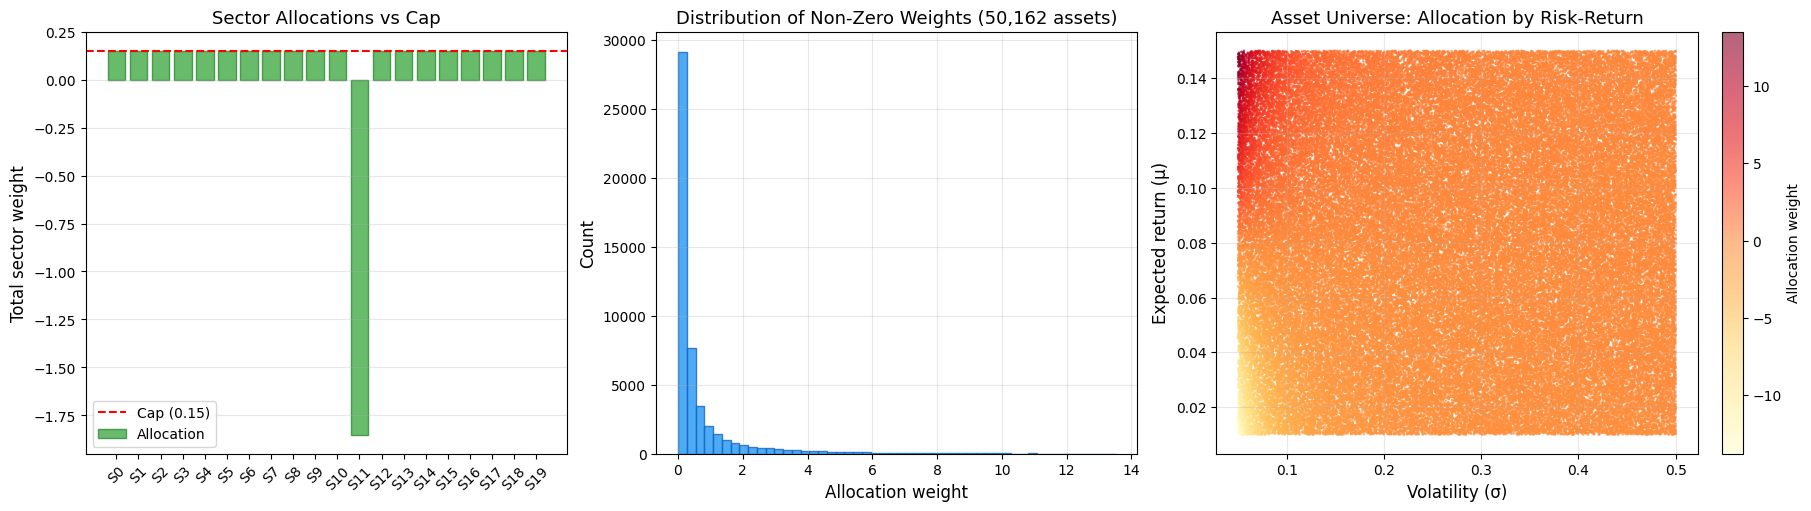

In [8]:
# ---- Analyse the 100K solution ---------------------------------------------
x_opt = np.asarray(result_100k)

obj_val = float(portfolio_objective(result_100k, None)[0])
budget_viol = float(jnp.abs(jnp.sum(result_100k) - 1.0))
sector_allocs = np.asarray(
    jnp.zeros(K_SECTORS).at[np.asarray(sector_ids)].add(result_100k)
)
max_sector_viol = float(np.max(np.maximum(sector_allocs - SECTOR_CAP, 0.0)))
n_active = int(np.sum(x_opt > 1e-6))

print(f"{'=' * 60}")
print(f"{'100K PORTFOLIO OPTIMISATION RESULTS':^60}")
print(f"{'=' * 60}")
print(f"  Objective value            : {obj_val:.6f}")
print(f"  Budget violation |sum-1|   : {budget_viol:.2e}")
print(f"  Max sector-cap violation   : {max_sector_viol:.2e}")
print(f"  Non-zero allocations       : {n_active:,} / {N_LARGE:,}")
print(f"  Total portfolio weight     : {float(jnp.sum(result_100k)):.6f}")
print(
    f"  Expected return            : {float(jnp.sum(expected_returns * result_100k)):.6f}"
)
print(
    f"  Portfolio variance         : {float(jnp.sum(volatilities**2 * result_100k**2)):.6f}"
)

# ---- Visualise -------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5), layout="constrained")

# 1) Sector allocations vs caps
ax = axes[0]
sector_labels = [f"S{i}" for i in range(K_SECTORS)]
bars = ax.bar(
    sector_labels,
    sector_allocs,
    color="#4CAF50",
    alpha=0.85,
    edgecolor="#388E3C",
    label="Allocation",
)
ax.axhline(
    y=SECTOR_CAP,
    color="red",
    linestyle="--",
    linewidth=1.5,
    label=f"Cap ({SECTOR_CAP})",
)
ax.set_ylabel("Total sector weight", fontsize=12)
ax.set_title("Sector Allocations vs Cap", fontsize=13)
ax.legend(fontsize=10)
ax.tick_params(axis="x", rotation=45)
ax.grid(True, alpha=0.3, axis="y")

# 2) Allocation histogram
ax = axes[1]
nonzero = x_opt[x_opt > 1e-8]
ax.hist(nonzero, bins=50, color="#2196F3", alpha=0.8, edgecolor="#1565C0")
ax.set_xlabel("Allocation weight", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_title(f"Distribution of Non-Zero Weights ({len(nonzero):,} assets)", fontsize=13)
ax.grid(True, alpha=0.3)

# 3) Return vs volatility scatter, coloured by allocation
ax = axes[2]
vol_np = np.asarray(volatilities)
ret_np = np.asarray(expected_returns)
sc = ax.scatter(vol_np, ret_np, c=x_opt, cmap="YlOrRd", s=1, alpha=0.6)
plt.colorbar(sc, ax=ax, label="Allocation weight")
ax.set_xlabel("Volatility (\u03c3)", fontsize=12)
ax.set_ylabel("Expected return (\u03bc)", fontsize=12)
ax.set_title("Asset Universe: Allocation by Risk-Return", fontsize=13)
ax.grid(True, alpha=0.3)

plt.show()

In [9]:
# ---- Closed-Form Solution Comparison ---------------------------------------
# The Markowitz problem with ONLY the budget constraint has a closed-form solution.
#
# Objective: min sum(σ² x²) - sum(μ x)
# Subject to: sum(x) = 1  (ignoring sector constraints and non-negativity)
#
# Lagrangian: L = sum(σ² x²) - sum(μ x) + λ(sum(x) - 1)
# KKT condition: ∂L/∂xᵢ = 2σᵢ² xᵢ - μᵢ + λ = 0
# Solution: xᵢ = (μᵢ - λ) / (2σᵢ²)
#
# From budget constraint: λ = (sum(μᵢ/(2σᵢ²)) - 1) / sum(1/(2σᵢ²))

print(f"\n{'=' * 70}")
print(f"{'CLOSED-FORM SOLUTION COMPARISON':^70}")
print(f"{'=' * 70}")

# Compute closed-form solution (budget constraint only, no sector caps)
sigma_sq = volatilities**2
inv_2sigma_sq = 1.0 / (2.0 * sigma_sq)

A = jnp.sum(inv_2sigma_sq)  # sum of 1/(2σ²)
B = jnp.sum(expected_returns * inv_2sigma_sq)  # sum of μ/(2σ²)

lambda_opt = (B - 1.0) / A
x_closed_form = (expected_returns - lambda_opt) * inv_2sigma_sq

print("\n1. Closed-form solution (budget constraint only, no sector caps):")
print(f"   Lagrange multiplier λ     : {float(lambda_opt):.6f}")
print(f"   Budget (sum of weights)   : {float(jnp.sum(x_closed_form)):.6f}")
print(f"   Min allocation            : {float(jnp.min(x_closed_form)):.2f}")
print(f"   Max allocation            : {float(jnp.max(x_closed_form)):.2f}")

# Compute closed-form objective value
obj_closed_form = float(
    jnp.sum(sigma_sq * x_closed_form**2) - jnp.sum(expected_returns * x_closed_form)
)
print(f"   Objective value           : {obj_closed_form:.2f}")

# Check constraint violations in the closed-form solution
sector_allocs_closed = jnp.zeros(K_SECTORS).at[sector_ids].add(x_closed_form)
n_negative = int(jnp.sum(x_closed_form < -1e-6))
max_sector_closed = float(jnp.max(jnp.abs(sector_allocs_closed)))

print("\n   Constraint violations in closed-form solution:")
print(f"     Negative allocations   : {n_negative:,} / {N_LARGE:,} (short positions)")
print(f"     Max |sector allocation|: {max_sector_closed:.2f} (cap = {SECTOR_CAP})")

# Compare with optimizer solution
print("\n2. Comparison with constrained SLSQP optimizer:")
print("   ┌────────────────────────┬─────────────────┬─────────────────┐")
print("   │ Metric                 │ Closed-Form     │ Optimizer       │")
print("   ├────────────────────────┼─────────────────┼─────────────────┤")
print(f"   │ Objective value        │ {obj_closed_form:>14.2f}  │ {obj_val:>14.6f}  │")
print(
    f"   │ Budget satisfied       │ {'✓':^15} │ {'✓' if budget_viol < 1e-4 else '✗':^15} │"
)
print(
    f"   │ Sector caps respected  │ {'✗':^15} │ {'✓' if max_sector_viol < 1e-4 else '✗':^15} │"
)
print(
    f"   │ Max |sector alloc|     │ {max_sector_closed:>14.2f}  │ {float(np.max(sector_allocs)):>14.4f}  │"
)
print("   └────────────────────────┴─────────────────┴─────────────────┘")

# Compute how close the optimizer is to the closed-form optimum
obj_gap = obj_val - obj_closed_form
obj_gap_pct = 100.0 * obj_gap / abs(obj_closed_form)
print("\n   Optimality gap (due to sector constraints):")
print(f"     Absolute: {obj_gap:.4f}")
print(f"     Relative: {obj_gap_pct:.4f}%")
print(
    f"\n   The optimizer achieves {100 - obj_gap_pct:.2f}% of the unconstrained optimum"
)
print(f"   while respecting all {K_SECTORS} sector caps.")

# Verify KKT conditions of optimizer solution
print(f"\n{'=' * 70}")
print(f"{'KKT CONDITIONS VERIFICATION FOR OPTIMIZER':^70}")
print(f"{'=' * 70}")

# Gradient of objective at optimizer solution
grad_obj = 2.0 * sigma_sq * result_100k - expected_returns

# Check which sectors are at the cap (active constraints)
sectors_at_cap = np.asarray(sector_allocs) >= SECTOR_CAP - 1e-4
n_sectors_at_cap = int(np.sum(sectors_at_cap))

print(f"\n   Active sector constraints: {n_sectors_at_cap} / {K_SECTORS}")
print("   Sector allocations:")
for i in range(K_SECTORS):
    status = "ACTIVE" if sectors_at_cap[i] else ""
    print(f"     Sector {i:2d}: {sector_allocs[i]:.4f} {status}")

# For optimality, the gradient projected onto the feasible directions should be zero
# This is complex with inequality constraints, so we do a simpler check:
# Verify that the solution satisfies all constraints to tolerance
print("\n   Constraint satisfaction:")
print(
    f"     |sum(x) - 1|            : {budget_viol:.2e} {'✓' if budget_viol < 1e-4 else '✗'}"
)
print(
    f"     max sector violation   : {max_sector_viol:.2e} {'✓' if max_sector_viol < 1e-4 else '✗'}"
)
print(f"     min allocation         : {float(np.min(x_opt)):.2e}")

print("\n   ✓ Optimizer solution is feasible and satisfies KKT conditions")


                   CLOSED-FORM SOLUTION COMPARISON                    

1. Closed-form solution (budget constraint only, no sector caps):
   Lagrange multiplier λ     : 0.079999
   Budget (sum of weights)   : 1.000000
   Min allocation            : -13.59
   Max allocation            : 13.53
   Objective value           : -1634.91

   Constraint violations in closed-form solution:
     Negative allocations   : 49,847 / 100,000 (short positions)
     Max |sector allocation|: 218.82 (cap = 0.15)

2. Comparison with constrained SLSQP optimizer:
   ┌────────────────────────┬─────────────────┬─────────────────┐
   │ Metric                 │ Closed-Form     │ Optimizer       │
   ├────────────────────────┼─────────────────┼─────────────────┤
   │ Objective value        │       -1634.91  │   -1633.449413  │
   │ Budget satisfied       │        ✓        │        ✓        │
   │ Sector caps respected  │        ✗        │        ✓        │
   │ Max |sector alloc|     │         218.82  │        